## Problem Statement/Goal
 - Pull insights and see what I can do to predict a change.
 
 People who did the most sessions preferred which method?
 What other habits were formed by using more of the app?
 
Marajuana might be a great way for people to treat depression, anxiety and stress, at least in the short term before finding more sustainable and longterm solutions.  If one could build a model which could predict the potential change for a consumer, then a company might then be able to reccomend targeted suggestions for a specific customer based on what would be most effective and helpful for them.

All metrics will be in RMSE because I'm shooting to be able to predict the error within [a thingy]

## Imports

In [75]:
# Standard & quality of life imports
import pandas as pd   #loc[row_indexer,col_indexer]
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
from time import time
from datetime import datetime
%matplotlib inline

# Model prep & metric imports
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, Normalizer
from sklearn.decomposition import PCA

# Regression model imports
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRegressor

# Neural Network Imports
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Masking, Embedding
from keras import backend

df = pd.read_csv('./data/all_symptoms_cleaned.csv')

## Defining useful functions

In [76]:
df_results = pd.DataFrame(columns=['model','train_RMSE','test_RMSE','time'])

def run_model(model, X_train, X_test, y_train, y_test, 
              results_dataframe, run_notes = 'None', save = True):

    model      = model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test  = model.predict(X_test)
    dict_model = {'model' : re.findall(r'^[^@]+\(', str(model))[0].strip("("),
    'time'       : datetime.fromtimestamp(time()).strftime('%m/%d/%Y, %H:%M:%S'),
    'train_RMSE' : np.sqrt(metrics.mean_squared_error(y_train, pred_train)),
    'test_RMSE'  : np.sqrt(metrics.mean_squared_error(y_test, pred_test)),
    'run_notes'  : run_notes}
    
    # Printing current results
    print(dict_model['model'])
    print('Train : ' + str(dict_model['train_RMSE']))
    print('Test  : ' + str(dict_model['test_RMSE']))
    
    # Saving current results
    results_dataframe = results_dataframe.append(dict_model, ignore_index=True)
    if save == True:
        results_dataframe.to_csv('./data/modeling_results_' 
                        + datetime.fromtimestamp(time()).strftime('%m_%d_%Y'), 
                        index = False)
    
    return results_dataframe

# ML DF EDA

In [77]:
print('Number of users in study:', len(df['userid'].value_counts())) # (Post data cleaning)

Number of users in study: 1062


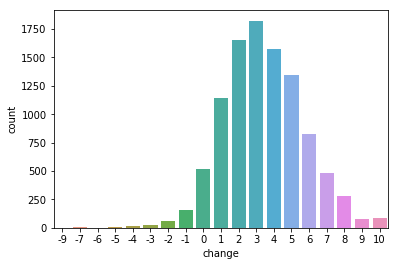

In [78]:
sns.countplot(df['change']);

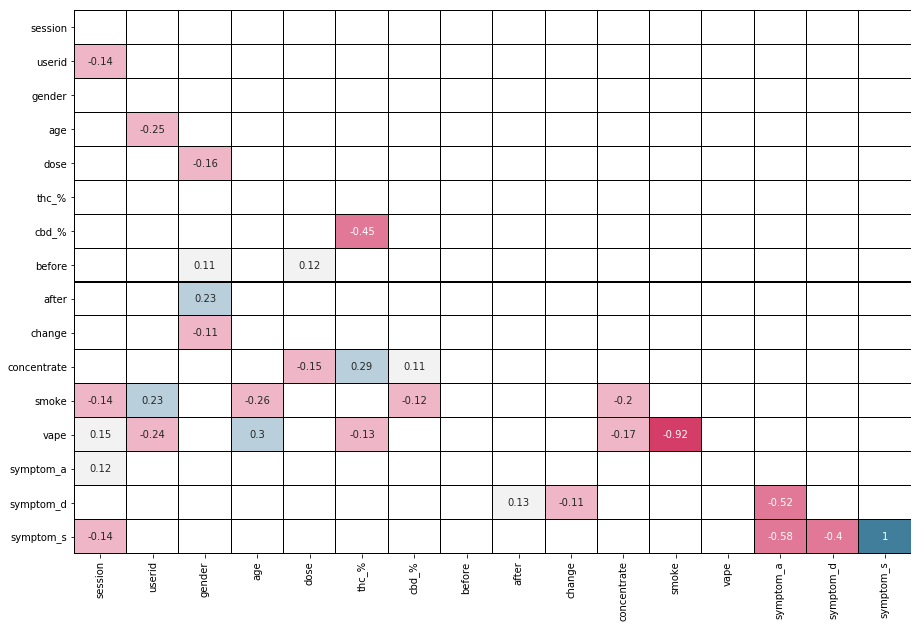

In [79]:
df_cor          = df.drop(['time_lag', 'dab_bubbler', 'dab_portable'],axis = 1).corr() 
# Dropped because nothing is signifigantly correlated to them
list_half_inner = []
list_half_outer = []

# Creating a blank-ish DF with the dementions that match the correlation matrix.
for i in range(df_cor.shape[0]):
    list_half_inner.append(True)
    list_half_outer.append(list_half_inner)
mask_half = pd.DataFrame(list_half_outer, columns= df_cor.columns, index=df_cor.columns)

# Turning it into a mask and cutting it in half.
for num in range(mask_half.shape[1]):
    mask_half.iloc[num,num:mask_half.shape[1]] = False

# Manually dropping certain values because they don't tell us anything by being correlated.
mask_half.loc['after','before'] = False
mask_half.loc['change','before':'after'] = False 

mask_half.iloc[df_cor.shape[0] - 1,df_cor.shape[1] - 1] = True
    
# Mask for limiting which correlations are shown.
mask_cor_limit = (df_cor > 0.1) | (df_cor < -0.1)
plt.figure(figsize=(15,10))

sns.heatmap(df_cor[mask_cor_limit][mask_half],
            annot = True, cbar=False, 
            linewidths= .01, linecolor='black', cmap=sns.diverging_palette(0, 230, n=7, center='light'));

---

# Baseline Models

In [80]:
# y will nearly always == the 'after' column, 
# thus we will define it once here and 
# shouldn't have to re-define it later
y = df['after']

In [81]:
# Removed features based on their redundancy when turned into dummie variables
# Along with the Change "feature" because that would essencially be redundant
df.drop(['concentrate', 'dab_bubbler','dab_portable', 'symptom_s', 'change'], axis = 1, inplace = True)

## Linear Regression

In [82]:
X = df.drop('after', axis = 1)

print('Linear Regression with all features.\n')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13)
df_results = run_model(LinearRegression(), X_train, X_test, y_train, y_test, df_results)

Linear Regression with all features.

LinearRegression
Train : 1.8533237594882133
Test  : 1.8410965564740691


The following is a Linear Regression with mostly just the "before" feature. ("symptom_a" is also included to keep X two dementional.


In [83]:
X = df[['before', 'symptom_a']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13)
df_results = run_model(LinearRegression(), X_train, X_test, y_train, y_test, df_results, 
                       run_notes = 'Only "Before" & "symptom_a" features ')

LinearRegression
Train : 1.9376655836011467
Test  : 1.9306675918513476


As far as linear regression is concerned, the most important value in our data is how somebody was feeling before attempting to medicate with cannabis.

## Random Forest & XGB

of the models I tried the one with the best consistent results was the Random Forrest Regressor.  I've also kept Linear Regression (it might provide insights and it's a coonsistent baseline) and XGBoost (I've always heard of how impressive XGB is and would like to use this opportunity to try it out.
Those I tried and deleted because they were redundant include:
Of the models tested these are the ones that I've tried and kept.  Most others were inferior versions of these three.

In [84]:
X = df.drop('after', axis = 1) # Redefining the X variable for our full feature list.

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13)
df_results = run_model(RandomForestRegressor(), X_train, X_test, y_train, y_test, df_results)

RandomForestRegressor
Train : 0.6562931667484591
Test  : 1.5615893212580223


As Random Forrest gives the best test RMSE score, I'm going to be gridsearching on that.
The other benefit of going with Random Forrest is that I hope to one day digure out a consistent way to pull the actual diagram of the trees.  As such, in the future, I'll be able to get insights from the model where as going forward with the Gradient Boosting Regressor (or even using an XG Boost) would potentially result in a more accurate model, but the expected improvement would be less valuable to me than the potential future insights.

In [85]:
df_results.sort_values('test_RMSE').head(5)

,model,train_RMSE,test_RMSE,time,run_notes
2,RandomForestRegressor,0.656293,1.561589,"08/09/2019, 20:55:00",None
0,LinearRegression,1.853324,1.841097,"08/09/2019, 20:54:59",None
1,LinearRegression,1.937666,1.930668,"08/09/2019, 20:54:59","Only ""Before"" & ""symptom_a"" features"


---

# Feature Engineering

## Engineering Mathimatical Features

In [86]:
# Feature representing total canabinoids in a product
df['total_%'] = (df['thc_%'] + df['cbd_%'])

# Feature representing a scale of having more THC than CBD or vice verca.  
# Not on a scale for human interpretation.
df['strain_ratio'] = (df['thc_%'] - df['cbd_%'])/(df['thc_%'] + df['cbd_%'])

## Gridsearching Time Bins

While I originally felt that there was some features which could be pulled from the time_lag feature if binned. I then decided to start with a guess of which splits would be the most useful and from there make a gridsearch-like code block with the correlation to the target variable to find what splits would actually have the most liklihood of being useful to the model.
I used a mock up of a gridsearch to find the most correlated combination of 3 different splits in the eature to find the one which would be most useful.
The next cell is the gridsearching code I used on the last set of numbers I tested.  After that is code for assigning it to the df and visualizing where the lines are in the actual data.

In [87]:
list_o_dicts = []
for low in [0, 14, 14.5, 15]:
    for mid in [0, 19, 19.5]:
        for high in [0, 100, 105]:
            def sorting(row):    
                if row['time_lag'] < low:
                    result = .1
                elif row['time_lag'] < mid:
                    result = .2
                elif row['time_lag'] < high:
                    result = .3
                else: 
                    result = .4
                return result
            df['binned_time'] = df.apply(sorting, axis=1)
            list_o_dicts.append({
                'low'  : low,
                'mid'  : mid,
                'high' : high,
                'corr' : np.abs(df.corrwith(df['after'])['binned_time'])
            })
df_grid = pd.DataFrame(list_o_dicts, columns=['corr','low','mid','high'])
df_grid = df_grid.sort_values('corr', ascending = False).head(10)
df_grid

,corr,low,mid,high
20,0.069518,14.5,0.0,105
11,0.069165,14.0,0.0,105
26,0.068723,14.5,19.5,105
23,0.068637,14.5,19.0,105
29,0.068630,15.0,0.0,105
18,0.068618,14.5,0.0,0
17,0.068584,14.0,19.5,105
14,0.068497,14.0,19.0,105
19,0.068494,14.5,0.0,100
9,0.068238,14.0,0.0,0


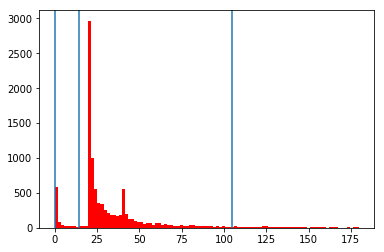

In [88]:
best_low, best_mid, best_high = df_grid.iloc[0,1], df_grid.iloc[0,2], df_grid.iloc[0,3]

def sorting(row):    
    if row['time_lag'] < best_low:
        result = .1
    elif row['time_lag'] < best_mid:
        result = .2
    elif row['time_lag'] < best_high:
        result = .3
    else: 
        result = .4
    return result
df['binned_time'] = df.apply(sorting, axis=1)

plt.axvline(x = best_low)
plt.axvline(x = best_mid)
plt.axvline(x = best_high)
plt.hist(df['time_lag'], bins = 100, color='red');

## Gridsearching Cannabis percentage classes

In [89]:
list_o_dicts = []
for slope_1 in [0.025, 0.05, 0.1]:
    for slope_2 in [0.7, 0.8, 0.85, 0.9]:
        def sorting(row):    
            if row['cbd_%'] < (row['thc_%'] * slope_1):
                result = 1
            elif row['cbd_%'] > (row['thc_%'] * slope_2):
                result = .5
            else: 
                result = 0
            return result
        df['strain_class'] = df.apply(sorting, axis=1)
        list_o_dicts.append({
            'slope_1'  : slope_1,
            'slope_2'  : slope_2,
            'corr' : np.abs(df.corrwith(df['after'])['strain_class'])
        })
df_grid = pd.DataFrame(list_o_dicts)
df_grid = df_grid.sort_values('corr', ascending= False).head(10)
df_grid

,corr,slope_1,slope_2
5,0.055640,0.050,0.80
6,0.055640,0.050,0.85
7,0.055418,0.050,0.90
4,0.053869,0.050,0.70
1,0.047656,0.025,0.80
2,0.047656,0.025,0.85
3,0.047503,0.025,0.90
0,0.045806,0.025,0.70
9,0.033004,0.100,0.80
10,0.033004,0.100,0.85


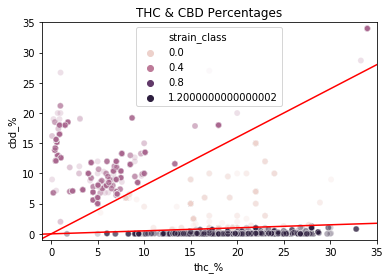

In [90]:
best_slope_1, best_slope_2 = df_grid.iloc[0,1], df_grid.iloc[0,2]


def sorting(row):    
    if row['cbd_%'] < (row['thc_%'] * best_slope_1):
        result = 1
    elif row['cbd_%'] > (row['thc_%'] * best_slope_2):
        result = .5
    else: 
        result = 0
    return result
df['strain_class'] = df.apply(sorting, axis=1)

axes = plt.gca()
axes.set_xlim([-1,35])
axes.set_ylim([-1,35])
axes.set_title('THC & CBD Percentages')
sns.scatterplot(df['thc_%'],df['cbd_%'], hue = df['strain_class'], alpha=0.2);
line = np.linspace(-500,500)
plt.plot(line, best_slope_1 * line, '-r');
plt.plot(line, best_slope_2 * line, '-r');

In [91]:
def sort(x):
    if x == 0:
        result = 0
    else:
        result = 1
    return result
df['has_cbd'] = df['cbd_%'].map(lambda x: sort(x))

Gridsearching Age Bins was attempted but resulted very very little correlation to continue down that path.

While these were useful things to try, looking back I realize that the problem with attempting to make features fromt his while using a random forrest is that the model could easily make these splits of it's own accord.  
In retrosepct I believe that the best features to engineer would be those that would provide a different scale that would then be more likely to be correlative to the target variable.

## Combining Dummies

In [92]:
# dd stands for "Double Dummies"
df['dd_gender_vape']  = df['gender'] * df['vape']
df['dd_gender_smoke'] = df['gender'] * df['smoke']
df['dd_gender_symptom_a'] = df['gender'] * df['symptom_a']
df['dd_gender_symptom_d'] = df['gender'] * df['symptom_d']
#df['dd_sym_a_vape']  = df['symptom_a'] * df['vape'] 
#df['dd_sym_d_vape']  = df['symptom_d'] * df['vape'] 
#df['dd_sym_a_smoke'] = df['symptom_a'] * df['smoke']
#df['dd_sym_d_smoke'] = df['symptom_d'] * df['smoke']
df['dd_sym_a_before'] = df['symptom_a'] * df['before']
df['dd_sym_d_before'] = df['symptom_d'] * df['before']

# td stands for "Triple Dummies"
df['td_sym_a_gender_before'] = df['gender'] * df['dd_sym_a_before']
df['td_sym_d_gender_before'] = df['gender'] * df['dd_sym_d_before']

# After the next section I decided to drop any double features that didn't involve the Before or Gender features.

## Modeling (Post Feature Creation)

In [103]:
X = df.drop('after', axis = 1)
X = Normalizer().fit_transform(X)
df_results = run_model(RandomForestRegressor(), X_train, X_test, y_train, y_test, df_results)

RandomForestRegressor
Train : 0.6416125518306719
Test  : 1.527657058711217


---

# Feature Importance (PCA, Correlation and More!)

In [94]:
abs(df.corrwith(df['after'])).sort_values(ascending = False)

after                     1.000000
before                    0.420261
td_sym_d_gender_before    0.263370
dd_sym_d_before           0.232150
gender                    0.226082
dd_gender_vape            0.205179
dd_gender_symptom_d       0.192911
td_sym_a_gender_before    0.137038
symptom_d                 0.126244
age                       0.080671
dd_gender_symptom_a       0.075977
dd_gender_smoke           0.073319
vape                      0.072438
userid                    0.070336
binned_time               0.069518
symptom_a                 0.061898
has_cbd                   0.055763
strain_class              0.055640
smoke                     0.055589
dd_sym_a_before           0.040280
dose                      0.027489
session                   0.025282
total_%                   0.015404
thc_%                     0.011204
time_lag                  0.010714
strain_ratio              0.009239
cbd_%                     0.004369
dtype: float64

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13)
model = RandomForestRegressor().fit(X_train,y_train)
pd.DataFrame(model.feature_importances_,
            index = df.drop('after', axis = 1).columns,
            columns=['importance']).sort_values('importance',ascending=False)

,importance
before,0.161605
session,0.077304
age,0.071587
dose,0.068161
gender,0.054651
userid,0.047105
dd_gender_vape,0.044265
total_%,0.044258
time_lag,0.039649
strain_class,0.039079


In [104]:
pca = PCA(svd_solver='auto')
X = pca.fit_transform(X)

In [105]:
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
print('Cumulative explained variance: ', cum_var_exp)

Cumulative explained variance:  [0.74999719 0.88598052 0.95520349 0.97115986 0.98169229 0.98994137
 0.99509748 0.99706586 0.99846118 0.99920342 0.99970673 0.99983826
 0.99989528 0.99993797 0.99995871 0.99997045 0.9999803  0.99998589
 0.99999084 0.99999547 0.99999769 0.99999868 0.99999943 0.99999978
 1.         1.        ]


In [106]:
X = PCA(n_components = 20, svd_solver='auto').fit_transform(X)

## Modeling (Post Redundant Feature Dropping)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13)
df_results = run_model(RandomForestRegressor(), X_train, X_test, y_train, y_test, df_results, 
                       run_notes = "Pruning Features")

RandomForestRegressor
Train : 0.7343554687104966
Test  : 1.7477284826215467


In [111]:
df_results

,model,train_RMSE,test_RMSE,time,run_notes
0,LinearRegression,1.853324,1.841097,"08/09/2019, 20:54:59",None
1,LinearRegression,1.937666,1.930668,"08/09/2019, 20:54:59","Only ""Before"" & ""symptom_a"" features"
2,RandomForestRegressor,0.656293,1.561589,"08/09/2019, 20:55:00",None
3,RandomForestRegressor,0.667403,1.549515,"08/09/2019, 20:55:18",None
4,RandomForestRegressor,0.654006,1.580396,"08/09/2019, 20:57:45",None
5,RandomForestRegressor,0.641613,1.527657,"08/09/2019, 20:59:09",None
6,RandomForestRegressor,0.661383,1.545749,"08/09/2019, 20:59:24",
7,RandomForestRegressor,0.657786,1.560214,"08/09/2019, 20:59:37",foewp
8,RandomForestRegressor,0.734355,1.747728,"08/09/2019, 21:00:12",foewp


------------------------

## Splitting Train & Test by a User's Last Session

In [113]:
list_last_session_indexes = []
list_ids = [i for i in df['userid'].unique()]
for i in list_ids:
    mask = df['userid'] == i
    list_last_session_indexes.append(df[mask]['session'].argmax())

df_test  = df.loc[list_last_session_indexes]
df_train = df.drop(list_last_session_indexes)

In [114]:
X_train = df_train.drop('after', axis = 1)
y_train = df_train['after']
X_test  = df_test.drop('after', axis = 1)
y_test  = df_test['after']

In [115]:
df_results = run_model(RandomForestRegressor(), X_train, X_test, y_train, y_test, df_results)

RandomForestRegressor
Train : 0.6364571945525223
Test  : 1.8310206265468243


Across the board it's worse than just pulling random samples.  This is unfortunate for my hopes of getting the RMSE score down, but I don't regret putting in the work to represent 

In [141]:
num = 1
mask = df_test['session'] > num
df_test_without_newbies = df_test[mask]
print('observations in training set:', df_train.shape[0])
print('Observations with at least', num, 'sessions:', df_test_without_newbies.shape[0])
X_train = df_train.drop('after', axis = 1)
y_train = df_train['after']
X_test  = df_test_without_newbies.drop('after', axis = 1)
y_test  = df_test_without_newbies['after']
df_results = run_model(RandomForestRegressor(), X_train, X_test, y_train, y_test, df_results)

Observations with at least 1 sessions: 647
RandomForestRegressor
Train : 0.6500354612376729
Test  : 1.8019909991592646


In [139]:
num = 5
mask = df_test['session'] > num
df_test_without_newbies = df_test[mask]
print('Observations with at least', num, 'sessions:', df_test_without_newbies.shape[0])
X_train = df_train.drop('after', axis = 1)
y_train = df_train['after']
X_test  = df_test_without_newbies.drop('after', axis = 1)
y_test  = df_test_without_newbies['after']
df_results = run_model(RandomForestRegressor(), X_train, X_test, y_train, y_test, df_results)

Observations with at least 5 sessions: 273
RandomForestRegressor
Train : 0.6390690435239216
Test  : 1.5067248521942487


Hmm.  While it's still not enough in range of the baseline, it IS better than with those for whome it's only been thier first time.

In [129]:
num = 10
mask = df_test['session'] > num
df_test_without_newbies = df_test[mask]
print('Observations with at least', num, 'sessions:', df_test_without_newbies.shape[0])
X_train = df_train.drop('after', axis = 1)
y_train = df_train['after']
X_test  = df_test_without_newbies.drop('after', axis = 1)
y_test  = df_test_without_newbies['after']
df_results = run_model(RandomForestRegressor(), X_train, X_test, y_train, y_test, df_results)

(152, 27)
RandomForestRegressor
Train : 0.6383594419765647
Test  : 1.5231114276547961


---

# Finally, Gridsearching

In [121]:
# Last gridsearch after about 10 trials.
params = {
    'n_estimators'      : [100, 200, 300],
    'max_features'      : [4, 5, 6],
    'min_samples_split' : [5, 6, 7],
    'min_samples_leaf'  : [4, 5, 6]
}
grid_RForest = GridSearchCV(RandomForestRegressor(), params, cv=3, n_jobs= 3, verbose = 1)


df_results = run_model(grid_RForest, X_train, X_test, y_train, y_test, df_results)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13)
df_results = run_model(LinearRegression(), X_train, X_test, y_train, y_test, df_results)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   28.0s


KeyboardInterrupt: 

In [ ]:
grid_RForest.best_params_

 - n_estimators = number of trees in the foreset
 - max_features = max number of features considered for splitting a node
 - max_depth = max number of levels in each decision tree
 - min_samples_split = min number of data points placed in a node before the node is split
 - min_samples_leaf = min number of data points allowed in a leaf node

---

## End Notes

Notes:
dd - Tactics skipped or dropped:
     - Nieve Bayes (Tried and wasn't very effective.)
     - PCA (Not needed.  We have too few features and can intuit which ones should be dropped.)
     - Ada (Not very effective and not my wheelhouse.)
     - Extra Trees (Random Forest functioned better.  This points to a potential prefrence for bagging and thus altering the ratio of certain data and/or the random splits of Extra Trees proved ueless for this data.)
     - XGBoost - Surprisingly performed slightly worse than Random Forrest and 
     
 - Tactics attempted and kept because of interest:
     - Attaching simpler models to Neural Network. (It's possible that I didn't do this well enough, yet.)
     - Poly features.  Ehh?